# Tổng hợp code từ sources:
1. https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data
2. https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities
3. https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities

## Tổng quan

Vì dữ liệu 191GB nên em up sample dataset với 30 ảnh lên để tổng quan về dữ liệu trước.
Download tại [link](https://drive.google.com/drive/folders/1xEcsZFq596lOIqejHgZTmNRs_SMdGnd4?usp=sharing)


Dữ liệu được lưu dưới định dạng DICOM

Tập train với 15,000 ảnh

Tập public test với 3,000 ảnh

Ảnh được gắn với 14 nhãn:

0 - Aortic enlargement

1 - Atelectasis

2 - Calcification

3 - Cardiomegaly

4 - Consolidation

5 - ILD

6 - Infiltration

7 - Lung Opacity

8 - Nodule/Mass

9 - Other lesion

10 - Pleural effusion

11 - Pleural thickening

12 - Pneumothorax

13 - Pulmonary fibrosis

14 - "No finding" observation was intended to capture the absence of all findings above

**Ở đây nhãn được gắn bởi nhiều chuyên gia X quang, nghĩa là một ảnh sẽ có nhiều ground-truth!**

### Dữ liệu mẫu

Mô tả dữ liệu:

train.csv: metadata của tập train, với mỗi hàng là một mẫu ảnh, bao gồm tên nhãn và bounding box (một ảnh có thể có nhiều hàng)

![figures](figures/overview_data.PNG)

Các cột trong train.csv

- image_id: tên dữ liệu
- class_name: tên của nhãn có trong ảnh (nêu không có thì hiện "No finding")
- class_id: ID của nhãn có trong ảnh (từ 0 đến 14)
- rad_id: ID của chuyên gia X quang, người gắn nhãn
- x_min: minimum X coordinate of the object's bounding box
- y_min: minimum Y coordinate of the object's bounding box
- x_max: maximum X coordinate of the object's bounding box
- y_max: maximum Y coordinate of the object's bounding box

sample_submission.csv: sample submission file in the correct format

**Đầu ra của bài toán là một model có thể khoanh vùng và phân loại 14 loại bất thưởng trong ảnh**

Tìm hiểu sâu về 14 loại bất thường có thể tham khảo repo sau:

[https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities](https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities)


## Visualize dữ liệu

#### Import libraries

In [1]:
import os
from tqdm import tqdm
import sys
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

#### Setup global variables

In [2]:
DATA_DIR = "E:/Kaggle/VinBigData/sample_dataset"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [3]:
# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")


... The number of training files is 20 ...
... The number of testing files is 10 ...


In [4]:
# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

In [5]:
# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
ss_df = pd.read_csv(SS_CSV)

### Tìm hiểu về định dạng DICOM?

Tham khảo tại: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [12]:
test_dicom = pydicom.read_file(TRAIN_DICOM_PATHS[2])

In [13]:
test_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 00a7e1e81b2122e5a0f298155573e549
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0010, 1010) Patient's Age                       AS: 'Y'
(0010, 1020) Patient's Size                      DS: None
(0010, 1030) Patient's Weight                    DS: None
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation         

Chuyển từ định dạng DICOM về np.array cần lưu ý:

Source: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

" you must consider, that raw dicom data is not actually linearly convertable to "human-friendly" png/jpg. In fact, most of DICOM's store pixel values in exponential scale, which is resolved by standard standard DICOM viewers.

So in order to get jpg/png as radiologists would initially see in their workspace, you need to apply some transformations. DICOM metadata stores information how to make such "human-friendly" transformations."


In [6]:
# dicom2array
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [7]:
imgs = dicom2array(TRAIN_DICOM_PATHS[2])

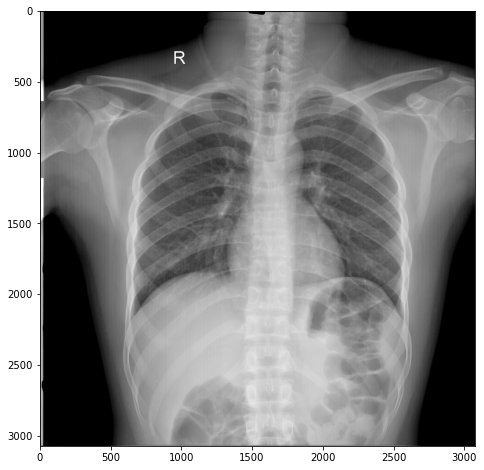

In [8]:
plt.figure(figsize = (8,8))
plt.imshow(imgs, 'gray')
plt.show()

## Plot with bounding box

Bounding box coordinates

![figure](figures/bbox.PNG)

In [9]:
def get_bbox_data():
    bbox_df = train_df[train_df.class_id!=14].reset_index(drop=True)
    BBOX_PATHS = [
        os.path.join(TRAIN_DIR, name+".dicom") \
        for name in bbox_df.image_id.unique()
    ]
    return BBOX_PATHS

In [10]:
BBOX_PATHS = get_bbox_data()